In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [4]:
def load_wav_files(folder):
    files = []
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            filepath = os.path.join(folder, file)
            audio, sr = librosa.load(filepath, sr=None)  # Load audio with original sampling rate
            files.append(audio)
    return files

# Replace 'path_to' with actual path to your folders
train_clean = load_wav_files(r"C:\Users\Bala cheran\Desktop\Real-Time-Noise-Cancellation-System\clean_train")
test_clean = load_wav_files(r"C:\Users\Bala cheran\Desktop\Real-Time-Noise-Cancellation-System\clean_test")


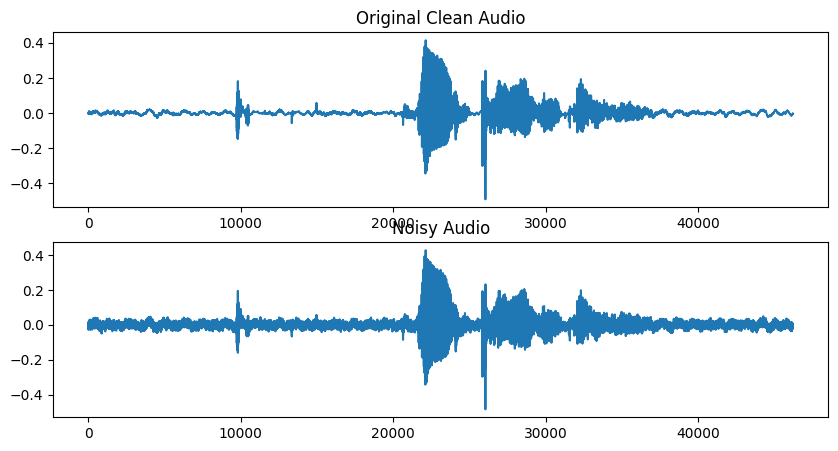

In [5]:
def add_noise(audio, noise_level=0.01):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

# Add noise to training and testing data
train_noisy = [add_noise(audio) for audio in train_clean]
test_noisy = [add_noise(audio) for audio in test_clean]

# Visualize an example
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title('Original Clean Audio')
plt.plot(train_clean[0])
plt.subplot(2, 1, 2)
plt.title('Noisy Audio')
plt.plot(train_noisy[0])
plt.show()


In [6]:
def extract_features(audio_list, n_mfcc=13):
    features = []
    for audio in audio_list:
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc)
        features.append(np.mean(mfcc.T, axis=0))  # Mean of MFCCs over time
    return np.array(features)

train_features_noisy = extract_features(train_noisy)
test_features_noisy = extract_features(test_noisy)
train_features_clean = extract_features(train_clean)
test_features_clean = extract_features(test_clean)


In [7]:
scaler_noisy = MinMaxScaler()
scaler_clean = MinMaxScaler()

X_train_noisy = scaler_noisy.fit_transform(train_features_noisy)
X_test_noisy = scaler_noisy.transform(test_features_noisy)

y_train_clean = scaler_clean.fit_transform(train_features_clean)
y_test_clean = scaler_clean.transform(test_features_clean)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, UpSampling1D

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train_noisy.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    LSTM(64, return_sequences=True),
    Dropout(0.2),
    
    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(13)  # Adjusted to match target shape
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 13, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 6, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 3, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13)                  │             429 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,109 (172.30 KB)

 Trainable params: 44,109 (172.30 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError()]
)

history = model.fit(
    X_train_reshaped, y_train_clean,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_reshaped, y_test_clean),
    callbacks=[early_stopping]
)


Epoch 1/100
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0428 - mean_absolute_error: 0.1533 - root_mean_squared_error: 0.1972 - val_loss: 0.0297 - val_mean_absolute_error: 0.1408 - val_root_mean_squared_error: 0.1723
Epoch 2/100
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0142 - mean_absolute_error: 0.0943 - root_mean_squared_error: 0.1193 - val_loss: 0.0304 - val_mean_absolute_error: 0.1392 - val_root_mean_squared_error: 0.1745
Epoch 3/100
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0118 - mean_absolute_error: 0.0857 - root_mean_squared_error: 0.1088 - val_loss: 0.0250 - val_mean_absolute_error: 0.1260 - val_root_mean_squared_error: 0.1581
Epoch 4/100
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0102 - mean_absolute_error: 0.0796 - root_mean_squared_error: 0.1009 - val_loss: 0.0228 - val_mean_absolute_error: 0.1197 - val_root_mean_squared_error: 0.1509
Epoch 5/100
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0092 - mean_absolute_erro

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


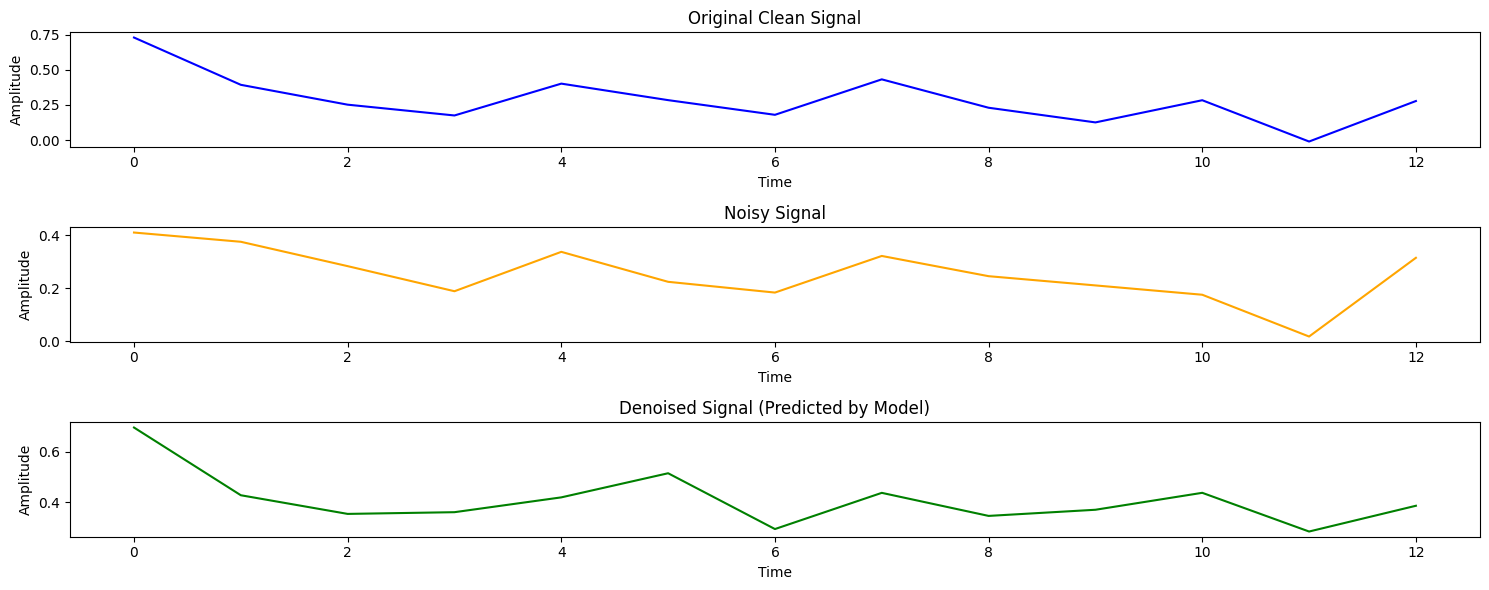

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Select a test sample and its clean counterpart
index = 1000  # You can change this to try different samples
test_sample_noisy = X_test_noisy[index]
test_sample_clean = y_test_clean[index]

# Reshape the test sample for the model prediction
test_sample_noisy_reshaped = test_sample_noisy.reshape(1, test_sample_noisy.shape[0], 1)

# Generate the denoised signal using the model
predicted_clean = model.predict(test_sample_noisy_reshaped)
predicted_clean = predicted_clean.flatten()  # Flatten for plotting

# Plot the results
plt.figure(figsize=(15, 6))

# Plot the clean signal
plt.subplot(3, 1, 1)
plt.plot(test_sample_clean, color='blue')
plt.title("Original Clean Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Plot the noisy signal
plt.subplot(3, 1, 2)
plt.plot(test_sample_noisy, color='orange')
plt.title("Noisy Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")

# Plot the denoised signal
plt.subplot(3, 1, 3)
plt.plot(predicted_clean, color='green')
plt.title("Denoised Signal (Predicted by Model)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [ ]:
model.save('finalmodel.h5')